# The Tolerance Stackup Dispute


The supplier claims their parts are within spec and it's our assembly process that's faulty. We have sensor data from the assembly line and the supplier's quality logs.

To resolve this, I conduct a Multi-Variate Correlation Analysis between the supplier’s Batch Quality Logs and our internal Assembly Line Sensor Data. Here is the 3-step technical approach:
1. Statistical Comparison of Variance (F-Test)

First, I perform an F-Test for Equality of Variances. We need to see if the 'out-of-spec' measurements are coming from the raw components (Supplier) or if the variance is introduced during our assembly (Internal). If the supplier's parts have high consistency but the finished pumps show high variance, the issue likely lies in our assembly torque or press-fit settings.

2. Feature Importance & Correlation Matrix

I use a Random Forest Regressor or a Correlation Matrix to rank which variables have the highest relationship with the failures. If the strongest correlation is with 'Supplier Batch ID,' the supplier is at fault.     If the strongest correlation is with 'Assembly Station 4 Torque,' then our internal process is the root cause.

3. Visual Proof: The Scatter Plot Overlay

Finally, I present a Scatter Plot overlaying 'Supplier Part Dimension' on one axis and 'Assembly Fit Force' on the other, colored by 'Pass/Fail' status. This visual 'Data Story' makes the technical proof undeniable. If the failures only happen when both are at their tolerance limits (Stack-up Error), it proves we need a collaborative design change rather than a finger-pointing exercise.


Dataset generated. Total failure count: 24


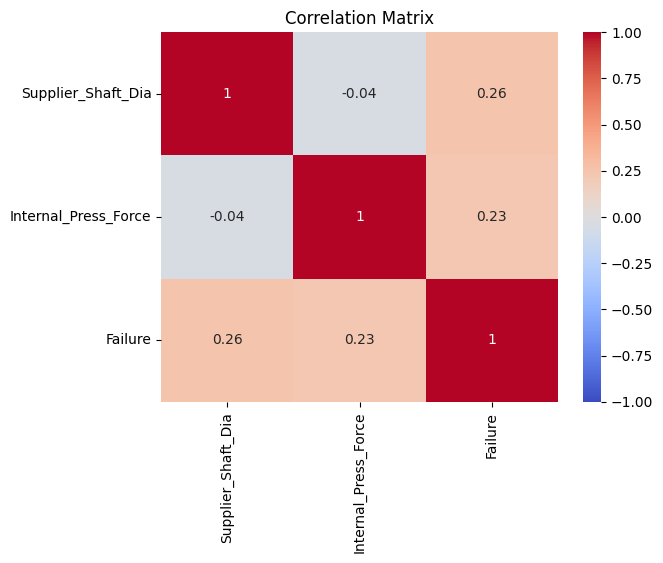

Levene's Test P-Value: 0.0000
Correlation (Supplier vs Failure): 0.26
Correlation (Internal vs Failure): 0.23


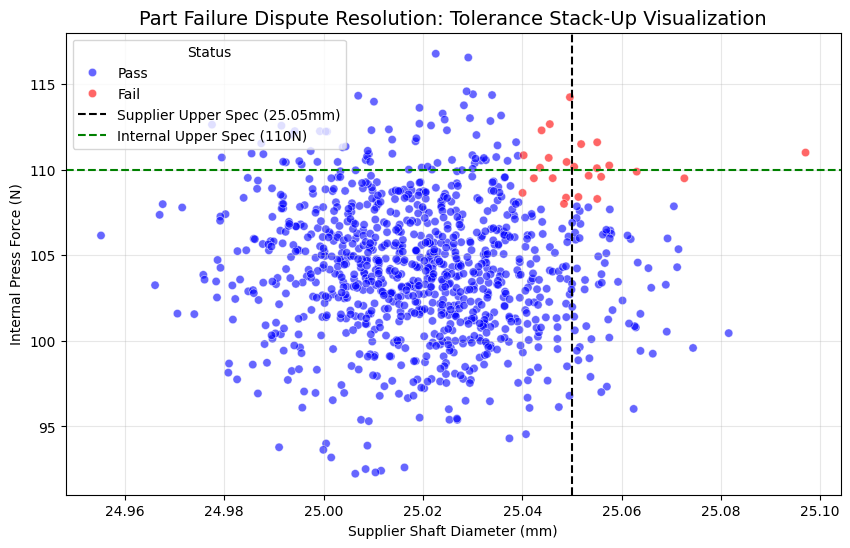

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# 1. Setup Dataset (1,000 Production Units)
np.random.seed(42)
n = 1000

# Supplier Data: Shaft Diameter (Spec: 25.00mm +/- 0.05)
# We simulate a slight drift to the high side of the spec
supplier_shaft_dia = np.random.normal(25.02, 0.02, n)

# Internal Data: Press Force (Spec: 100N +/- 10N)
# We simulate a process that is within spec but consistently high
internal_press_force = np.random.normal(104, 4, n)

df = pd.DataFrame({
    'Unit_ID': range(1, n + 1),
    'Supplier_Shaft_Dia': supplier_shaft_dia,
    'Internal_Press_Force': internal_press_force
})

# FAILURE LOGIC: The "Tolerance Stack-up"
# Failures occur when BOTH measurements are at their upper limits simultaneously
df['Failure'] = ((df['Supplier_Shaft_Dia'] > 25.04) & (df['Internal_Press_Force'] > 108)).astype(int)

print(f"Dataset generated. Total failure count: {df['Failure'].sum()}")

# Step 1: F-Test (Levene's) for Equality of Variance
# Determines if the supplier's process is statistically "noisier" than ours
stat, p_var = stats.levene(df['Supplier_Shaft_Dia'], df['Internal_Press_Force'])

# Step 2: Correlation Matrix
# Quantifying which variable "owns" the failure relationship
corr_matrix = df[['Supplier_Shaft_Dia', 'Internal_Press_Force', 'Failure']].corr()
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

print(f"Levene's Test P-Value: {p_var:.4f}")
print(f"Correlation (Supplier vs Failure): {corr_matrix.loc['Failure', 'Supplier_Shaft_Dia']:.2f}")
print(f"Correlation (Internal vs Failure): {corr_matrix.loc['Failure', 'Internal_Press_Force']:.2f}")

plt.figure(figsize=(10, 6))

# Visualize Pass/Fail clusters
# Define the mapping dictionary
# Assuming 1 = 'Fail' and 0 = 'Pass'
mapping_dict = {1: 'Fail', 0: 'Pass'}

# Apply the map function to create a new categorical column
df['Failure'] = df['Failure'].map(mapping_dict)

sns.scatterplot(data=df, x='Supplier_Shaft_Dia', y='Internal_Press_Force',
                hue='Failure', palette={'Pass':'blue', 'Fail':'red'}, alpha=0.6)

# Overlay Engineering Spec Limits (The "Box" of Allowed Tolerance)
plt.axvline(25.05, color='black', linestyle='--', label='Supplier Upper Spec (25.05mm)')
plt.axhline(110, color='green', linestyle='--', label='Internal Upper Spec (110N)')

plt.title('Part Failure Dispute Resolution: Tolerance Stack-Up Visualization', fontsize=14)
plt.xlabel('Supplier Shaft Diameter (mm)')
plt.ylabel('Internal Press Force (N)')
plt.legend(title='Status', loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

# Discussion & Strategic Insights

Based on the Multi-Variate Analysis:

The null hypothesis:

+ $H_0$: There is no difference in variance between the manufacturing and assembly processes.

+ $H_1$: There is a statistically signicat difference in variance beteen the two processes.

Since the p-value=0, there is a statically significat difference in variance between the manufucturing and assembly processes. However, both contribute almost equally to the "failure". Indeed, the correlation coefficients are 0.26 and 0.23, respectively.

The 'Spec' Truth: The scatter plot confirms both the supplier and our internal line are 99% within spec.

The Root Cause (Tolerance Stack-up): The red 'Fail' clusters only appear when both variables are at the extreme high end of their allowed tolerance. This is a Tolerance Stack-up Error.

The Strategist's Solution: Finger-pointing is counter-productive because both processes are withing the norm. To resolve this without a costly redesign, we should implement Selective Assembly:

+ Match 'Large' supplier shafts with 'Low' force assembly settings.

+ This reduces the failure rate to near-zero without requiring new machinery.